# Capstone Project: Grab Challenge(Traffic Management)

In [1]:
import pandas as pd
from datetime import datetime,timedelta

import geohash as gh
from math import sin, cos, radians, atan2,sqrt
import statsmodels.api as sm
import numpy as np

#Visualization
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
from mpl_toolkits.basemap import Basemap

import progressbar
from time import sleep

In [2]:
df = pd.read_csv('Processed_Grab.csv')

df.Timestamp = df.Timestamp.apply(lambda x: pd.Timestamp(x))

df.drop(columns = ['Unnamed: 0'],inplace = True)

df.head()

,geohash6,demand,latitude,longitude,day_of_week,Timestamp
0,qp03wc,0.020072,-5.353088,90.653687,D,2019-01-18 20:00:00
1,qp03pn,0.024721,-5.413513,90.664673,C,2019-01-10 14:30:00
2,qp09sw,0.102821,-5.325623,90.906372,B,2019-01-09 06:15:00
3,qp0991,0.088755,-5.353088,90.752563,D,2019-02-01 05:00:00
4,qp090q,0.074468,-5.413513,90.719604,A,2019-01-15 04:00:00


# 7. SARIMAX METHOD

Looking at the average demand for the whole location instead of each location

## 7.1. Data Preparation

In [3]:
df_S = pd.pivot_table(df ,values = 'demand', index = ['Timestamp'], columns = ['geohash6'],fill_value=0)

In [4]:
df_S.head()

geohash6,qp02yc,qp02yf,qp02yu,qp02yv,qp02yy,qp02yz,qp02z1,qp02z3,qp02z4,qp02z5,...,qp0djv,qp0djw,qp0djy,qp0dn0,qp0dn1,qp0dn4,qp0dn5,qp0dnh,qp0dnj,qp0dnn
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2019-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0006,...,0.0,0.0,0.004056,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2019-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.009381,0.0
2019-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2019-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.008253,0.0,0.0,0.0,0.0,0.0,0.002701,0.0


In [5]:
df_S['demand'] = df_S.loc[:,'qp02yc':'qp0dnn'].mean(axis=1)

df_S.drop(columns =  df_S.loc[:,'qp02yc':'qp0dnn'].columns,inplace=True)

In [6]:
df_S.head()

geohash6,demand
Timestamp,
2019-01-01 00:00:00,0.022744
2019-01-01 00:15:00,0.025120
2019-01-01 00:30:00,0.027232
2019-01-01 00:45:00,0.029258
2019-01-01 01:00:00,0.033303


In [7]:
df_S.sort_index(inplace=True)

df_S.head()

geohash6,demand
Timestamp,
2019-01-01 00:00:00,0.022744
2019-01-01 00:15:00,0.025120
2019-01-01 00:30:00,0.027232
2019-01-01 00:45:00,0.029258
2019-01-01 01:00:00,0.033303


### Save to CSV file

In [8]:
df_S.to_csv(r'C:\Users\Acer\Documents\01 Eskwelabs\Grab AI for SEA\Traffic Management\Averaged_All_Locs.csv')

## 7.2. Exploring the data

### 7.2.1. Monthly Trends

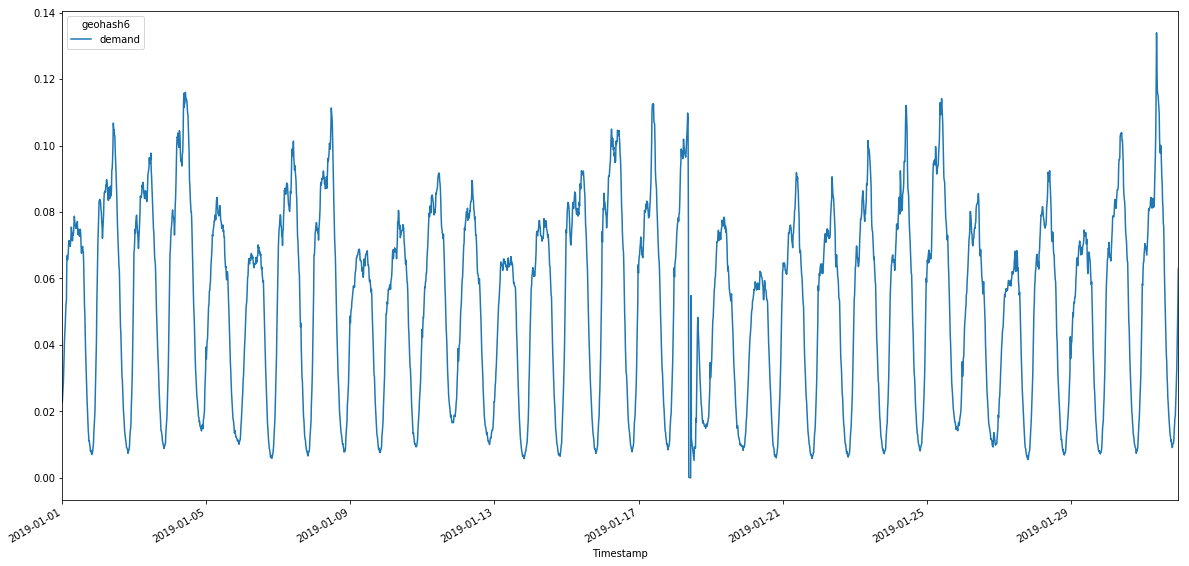

In [9]:
df_S['2019-01'].plot(figsize=(20,10))

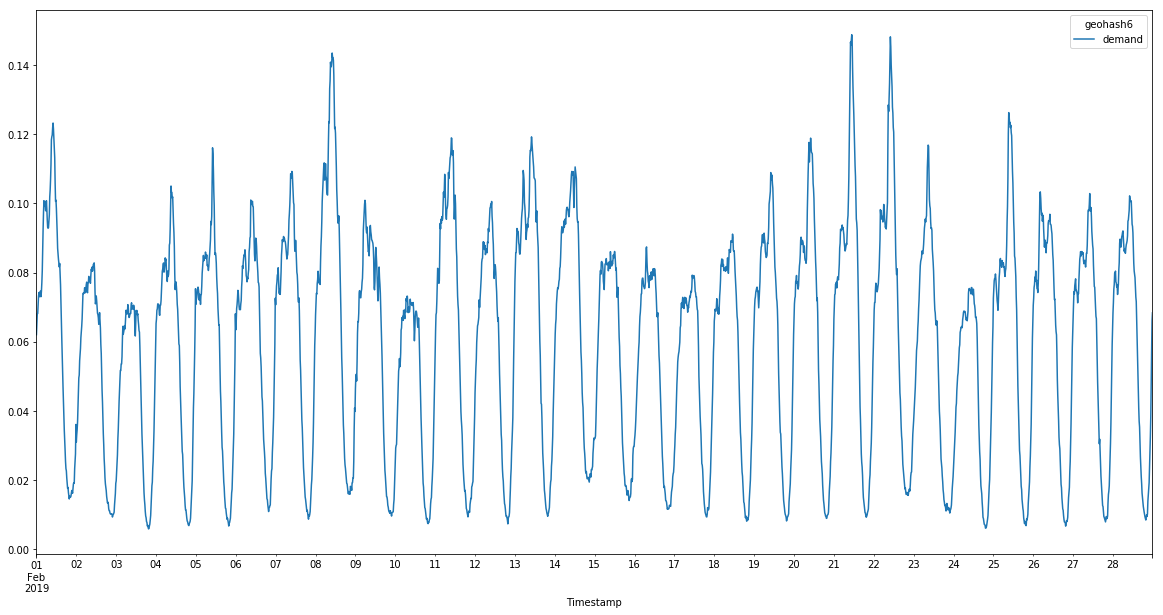

In [10]:
df_S['2019-02'].plot(figsize=(20,10))

### 7.2.2. Average Hourly demand for Day of the Week

In [11]:
df_day = pd.pivot_table(df ,values = 'demand', index = ['geohash6','day_of_week'], columns = ['Timestamp'],fill_value=0).reset_index()

df_day = df_day.groupby('day_of_week').aggregate('mean')

df_day = df_day.T

df_day.reset_index(inplace=True)

df_day = df_day.groupby(df_day['Timestamp'].dt.hour).mean()

In [12]:
df_day.head()

day_of_week,A,B,C,D,E,F,G
Timestamp,,,,,,,
0,0.009138,0.010529,0.009978,0.009382,0.005853,0.003543,0.008902
1,0.010129,0.011449,0.010892,0.010554,0.007545,0.005100,0.009573
2,0.010201,0.010994,0.010668,0.010940,0.009060,0.006579,0.009289
3,0.011062,0.011584,0.011404,0.012146,0.010446,0.007571,0.010128
4,0.012411,0.012773,0.012621,0.014313,0.011747,0.008517,0.011093


In [13]:
from matplotlib.lines import Line2D

def plot_days(ts_w):
    
    plt.figure(figsize=(10,5))
        
    for wd in range(0, 7):
        x_vals = ts_w.index
        y_vals = ts_w.iloc[:,[wd]]
        
        plt.plot(x_vals, y_vals, lw=3, label=wd)
        
    plt.legend(['A','B','C','D','E','F','G'], loc=2)
    plt.xlabel('Hour')
    plt.xticks(x_vals, x_vals)
    plt.xlim((0, 23))
    plt.ylim(ymin=0)

C:\Users\Acer\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


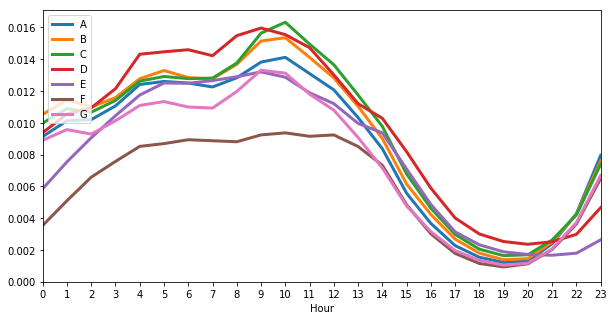

In [14]:
plot_days(df_day)

### 7.2.3. Random Day

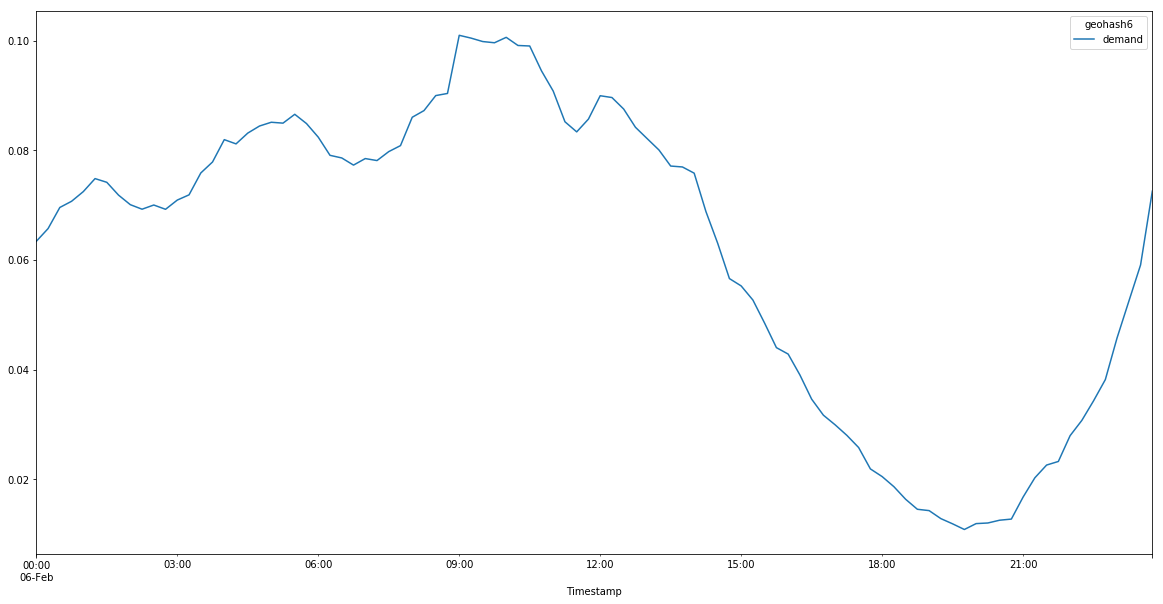

In [15]:
df_S['2019-02-06'].plot(figsize=(20,10))

## 7.3. Train Test Split

In [16]:
df_S_train = df_S[:'2019-02-19']
df_S_test = df_S['2019-02-20':]

In [17]:
df_S_train.head()

geohash6,demand
Timestamp,
2019-01-01 00:00:00,0.022744
2019-01-01 00:15:00,0.025120
2019-01-01 00:30:00,0.027232
2019-01-01 00:45:00,0.029258
2019-01-01 01:00:00,0.033303


In [18]:
df_S_test.head()

geohash6,demand
Timestamp,
2019-02-20 00:00:00,0.066160
2019-02-20 00:15:00,0.070937
2019-02-20 00:30:00,0.072564
2019-02-20 00:45:00,0.073076
2019-02-20 01:00:00,0.077409


## 7.4 Test for Stationarity

To create a time series model, the data must be stationary (e.i. there is constant mean, variance and covariance)

In [19]:
# adapted from https://www.analyticsvidhya.com/blog/2016
# /02/time-series-forecasting-codes-python/

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, rolling=96):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window = rolling).mean()
    rolstd = timeseries.rolling(window = rolling).std()

    #Plot rolling statistics:
    plt.figure(figsize=(20,10))
    orig = plt.plot(timeseries, color='darkgray',label='Original')
    mean = plt.plot(rolmean, color='darkblue', label='Rolling Mean', lw=1)
    std = plt.plot(rolstd, color='red', label = 'Rolling Std', lw=1)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.ylabel('Differenced # of Uber Pickups\nx(t) - x(t-1)')
    plt.xlim(timeseries.index.min(), timeseries.index.max())
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries)
    print('> ADF Statistic: {:.3f}'.format(result[0]))
    print('> p-value: {:.3e}'.format(result[1]))
    print('> Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

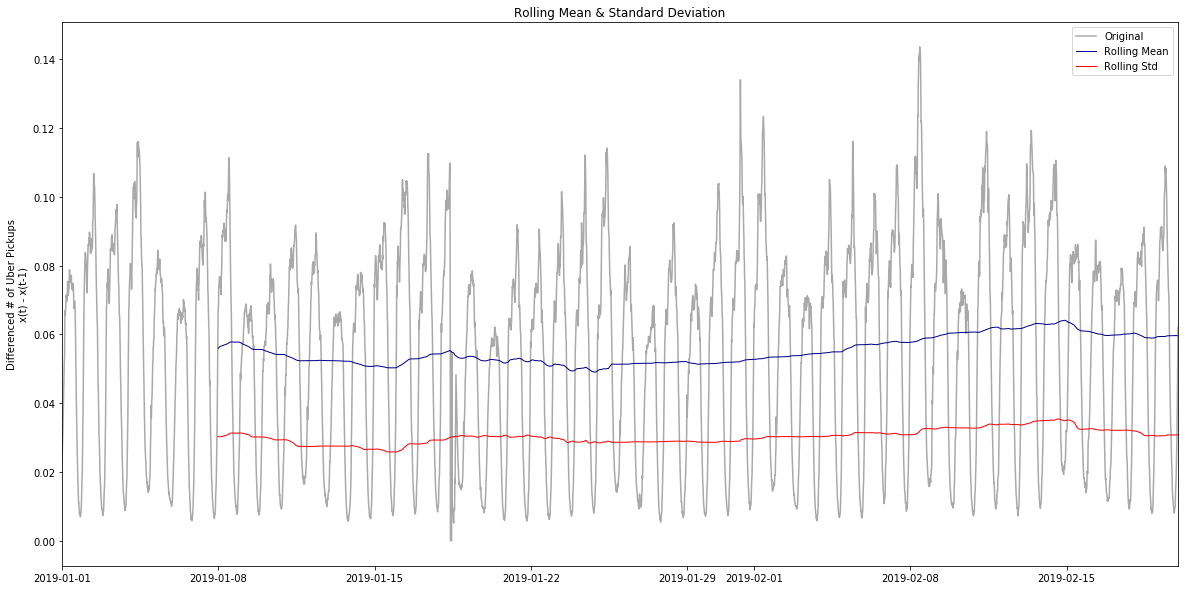

Results of Dickey-Fuller Test:
> ADF Statistic: -13.965
> p-value: 4.442e-26
> Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [20]:
test_stationarity(df_S_train.demand, rolling=672)

### 7.4.1. Differencing the time series

#### 1st order differencing

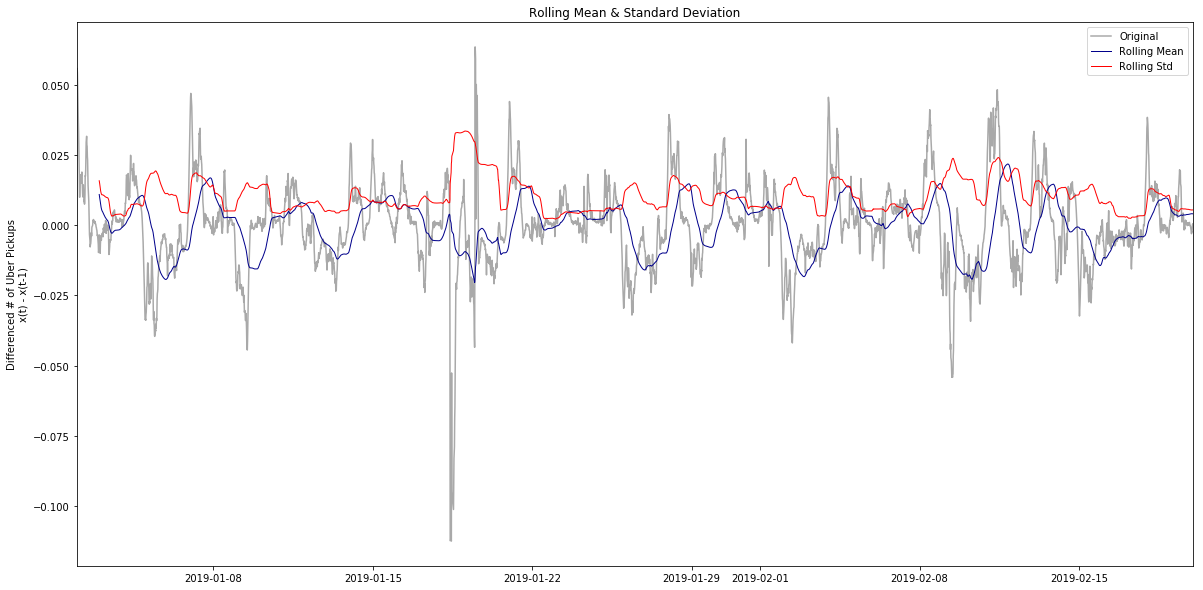

Results of Dickey-Fuller Test:
> ADF Statistic: -8.558
> p-value: 8.866e-14
> Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [21]:
# create a first-order differenced timeseries by
# subtracting the previous hour's value and
# removing the resulting n/a for the first value

diff = df_S_train.demand-df_S_train.demand.shift(96)
diff.dropna(inplace=True)

test_stationarity(diff)

#### 1st order + Seasonal Differencing

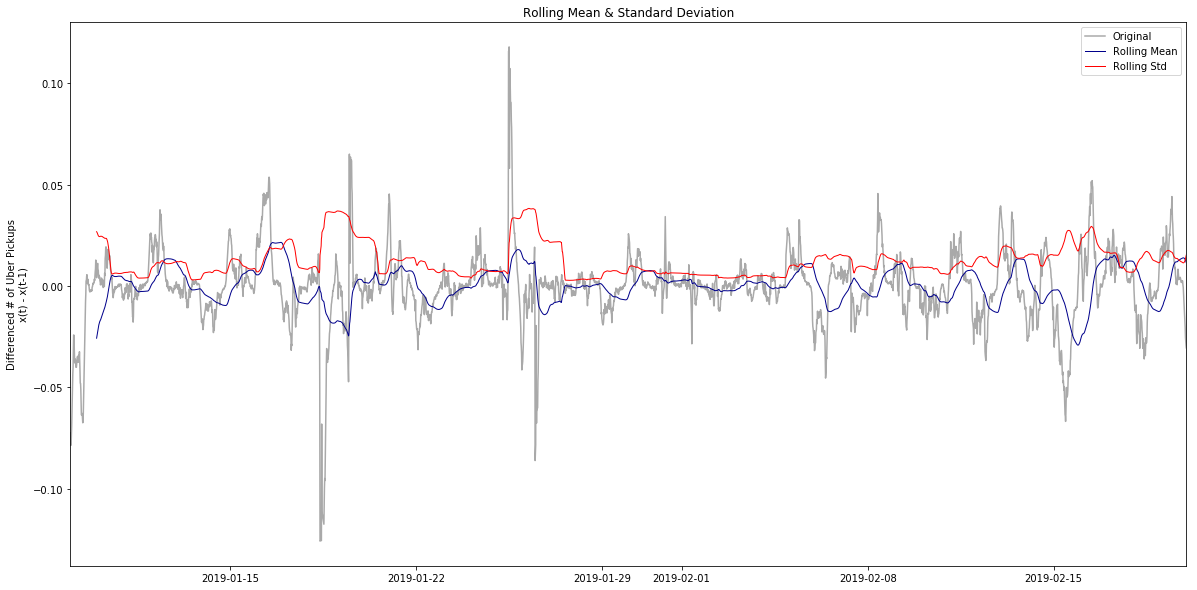

Results of Dickey-Fuller Test:
> ADF Statistic: -8.782
> p-value: 2.366e-14
> Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [22]:
diff = diff-diff.shift(672)
diff.dropna(inplace=True)

test_stationarity(diff)

## 7.5. Seasonal Decompose

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

### 7.5.1. Daily Seasonal Decompose

<Figure size 432x288 with 0 Axes>

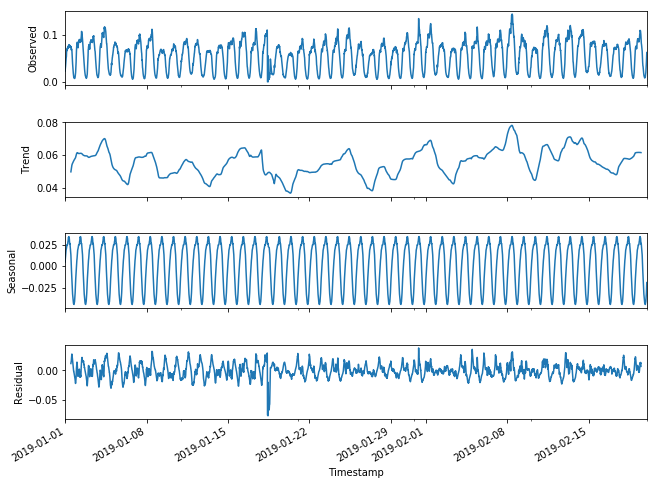

In [24]:
## Frequency derived from (24*60)min per day /15 min intervals
f = len(df_S['2019-01-01'])

decomposition = seasonal_decompose(df_S_train, freq=f)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(10, 8)



### 7.5.2. Weekly Seasonal Decompose

<Figure size 432x288 with 0 Axes>

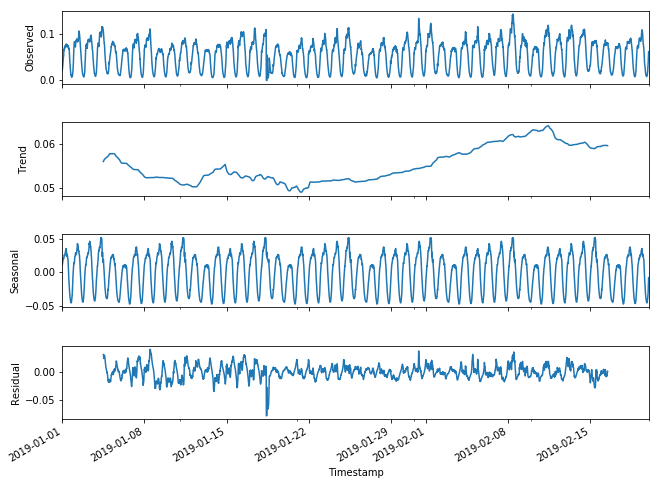

In [25]:
## Frequency derived from (24*60)min per day /15 min intervals * 7 days
f = len(df_S['2019-01-01':'2019-01-07'])
decomposition = seasonal_decompose(df_S_train, freq=f)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(10, 8)

## 7.6. Auto-Correlation Plots

Number of lags: 1344 (14.00 days)


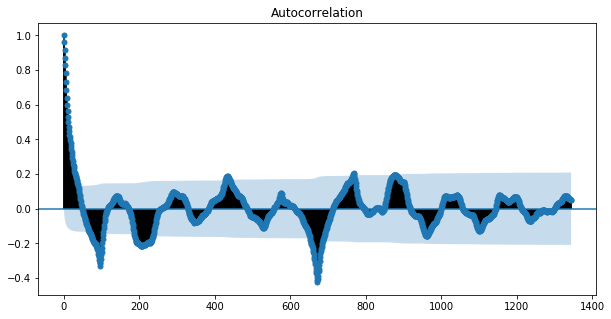

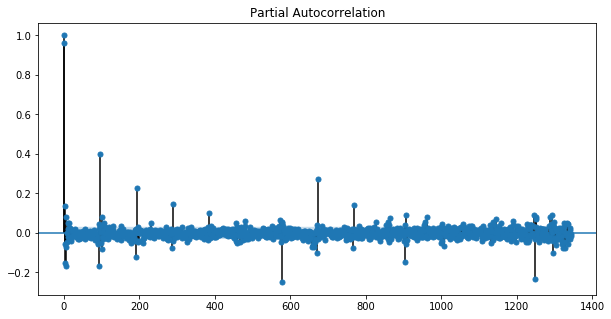

In [24]:
from statsmodels.graphics.tsaplots import plot_acf,  plot_pacf

lags_to_show = 672*2
print('Number of lags: {} ({:.2f} days)'.format(lags_to_show, 
                                                lags_to_show/96))

# plot autocorrelation 
fig, ax = plt.subplots(figsize=(10,5))
plot_acf(diff, ax = ax, lags=lags_to_show);

# plot PACF
fig, ax = plt.subplots(figsize=(10,5))
plot_pacf(diff, ax = ax, lags=lags_to_show);

## 7.7. Creating SARIMAX Model

In [26]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_actual, y_predicted, print_val=True):
    """
    Args:
    -----
    y_actual - Array of actual target values
    y_predicted - Array of predicted target values
    print_val - If `True` (default), RMSE will be
                printed. Otherwise, it will be 
                returned.
    """
    err = sqrt(mean_squared_error(y_actual, y_predicted))
    if print_val:
        print('RMSE: {:,.2f}'.format(err))
    else:
        return err
    
    
def plot_forecast(actual, pred, title='Actual vs Forecast', 
                  xlabel='Date', ylabel='Demand', 
                  grid=True, figsize=(10, 5)):
    
    if len(actual) != len(pred):
        return_str = 'Unequal lengths error: '
        return_str += '({} actual, '.format(len(actual))
        return_str += '{} forecast)'.format(len(pred))
        return return_str
    
    plt.figure(figsize=figsize)
    plt.plot(actual, label='Actual')
    plt.plot(actual.index, pred, label='Predicted', c='r')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #plt.xticks(actual.index.date[::24], actual.index.day[::24])
    plt.xlim(min(actual.index.date), max(actual.index.date))
    plt.legend(loc=0)
    plt.grid(True)

In [ ]:
# create SARIMAX model with previously determined lags

from statsmodels.tsa.statespace import sarimax

sar_m = sarimax.SARIMAX(df_S_train.values,
                        trend='ct', 
                        order=(2,1,1), 
                        seasonal_order=(2, 1, 1, 24), 
                        simple_differencing=False).fit()

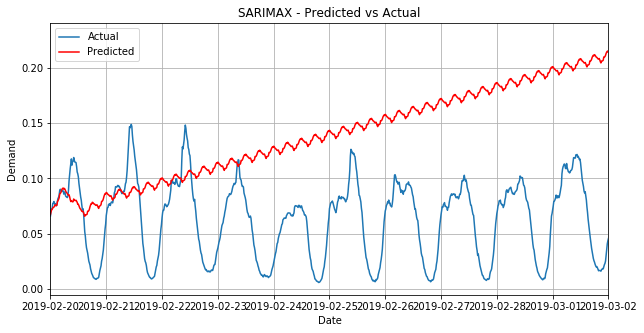

In [66]:
# forecast = results.predict(start = 168, end = 191)
predict_steps = 96*11
forecast = sar_m.forecast(steps=predict_steps)

# plot against real data
plot_forecast(df_S_test[:predict_steps], forecast, 
              title='SARIMAX - Predicted vs Actual', 
              xlabel='Date', 
              ylabel='Demand')


In [ ]:
# calculate RMSE error
rmse(df_S_test[:predict_steps].demand, forecast)